In [1]:
#importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

In [2]:
#import datasets
df_stores = pd.read_csv('data/stores.csv')
df_features = pd.read_csv('data/features.csv')
df_train = pd.read_csv('data/train.csv')
df_holdout = pd.read_csv('data/test.csv')

In [3]:
#Function to process features data set    
def process_features(df):
    df['formatted_date'] = pd.to_datetime(df['Date'])
    df['week_of_year'] = df.formatted_date.apply(lambda x: x.weekofyear)
    df['month_of_year'] = df.formatted_date.apply(lambda x: x.month)
    df['fortnight_of_year']=df['week_of_year'] // 2 + df['week_of_year'] % 2
    df['quarter_of_year']=df['week_of_year'] // 13 + 1
    df.replace({'quarter_of_year': {5: 4}},inplace=True)
    
    #Grouping Markdown by fortnight of year assuming the average of markdowns is same accross different fortnights in a year
    #Group cpi & unemployment index by quarter and store. As they tend to remain same per quarter in a particular region
    markdown1_mean=df.groupby(['Store','fortnight_of_year'])['MarkDown1'].mean().reset_index()
    markdown2_mean=df.groupby(['Store','fortnight_of_year'])['MarkDown2'].mean().reset_index()
    markdown3_mean=df.groupby(['Store','fortnight_of_year'])['MarkDown3'].mean().reset_index()
    markdown4_mean=df.groupby(['Store','fortnight_of_year'])['MarkDown4'].mean().reset_index()
    markdown5_mean=df.groupby(['Store','fortnight_of_year'])['MarkDown5'].mean().reset_index()
    cpi_mean=df.groupby(['Store','quarter_of_year'])['CPI'].mean().reset_index()
    unemployment_mean=df.groupby(['Store','quarter_of_year'])['Unemployment'].mean().reset_index()

    markdown_merged=pd.concat([markdown1_mean,markdown2_mean,markdown3_mean,markdown4_mean,markdown5_mean], axis=1)
    quarter_merged = pd.concat([cpi_mean,unemployment_mean], axis=1)
    markdown_merged = markdown_merged.loc[:,~markdown_merged.columns.duplicated()]
    quarter_merged = quarter_merged.loc[:,~quarter_merged.columns.duplicated()]

    df_features_merged=pd.merge(df, markdown_merged,  how='left', left_on=['Store','fortnight_of_year'], right_on = ['Store','fortnight_of_year'])
    df_features_merged_final=pd.merge(df_features_merged, quarter_merged,  how='left', left_on=['Store','quarter_of_year'], right_on = ['Store','quarter_of_year'])
    df_features_merged_final.head()

    df_features_merged_final.MarkDown1_x.fillna(df_features_merged_final.MarkDown1_y, inplace=True)
    df_features_merged_final.MarkDown2_x.fillna(df_features_merged_final.MarkDown2_y, inplace=True)
    df_features_merged_final.MarkDown3_x.fillna(df_features_merged_final.MarkDown3_y, inplace=True)
    df_features_merged_final.MarkDown4_x.fillna(df_features_merged_final.MarkDown4_y, inplace=True)
    df_features_merged_final.MarkDown5_x.fillna(df_features_merged_final.MarkDown5_y, inplace=True)
    df_features_merged_final.CPI_x.fillna(df_features_merged_final.CPI_y, inplace=True)
    df_features_merged_final.Unemployment_x.fillna(df_features_merged_final.Unemployment_y, inplace=True)

    df_features_merged_final[['MarkDown1_x','MarkDown2_x','MarkDown3_x','MarkDown4_x','MarkDown5_x']]=df_features_merged_final[['MarkDown1_x','MarkDown2_x','MarkDown3_x','MarkDown4_x','MarkDown5_x']].fillna(0)
    
    #Removing duplicate columns and renaming columns appropriately
    del df_features_merged_final['MarkDown1_y']
    del df_features_merged_final['MarkDown2_y']
    del df_features_merged_final['MarkDown3_y']
    del df_features_merged_final['MarkDown4_y']
    del df_features_merged_final['MarkDown5_y']
    del df_features_merged_final['CPI_y']
    del df_features_merged_final['Unemployment_y']
    
    df_features_merged_final.rename(columns={"MarkDown1_x": "MarkDown1", "MarkDown2_x": "MarkDown2", "MarkDown3_x": "MarkDown3",
                                   "MarkDown4_x": "MarkDown4", "MarkDown5_x": "MarkDown5","CPI_x":"CPI","Unemployment_x":"Unemployment"},inplace=True)
    
    
    return df_features_merged_final

In [4]:
#Functions to process train and test datasets
def map_size(store_type):
    if store_type=='A':
        return 1
    if store_type=='B':
        return 2
    if store_type=='C':
        return 3
def map_holiday(isHoliday):
    if isHoliday==True:
        return 1
    if isHoliday==False:
        return 0

def process_dataset(features,data):
    df_temp_merge=pd.merge(data,features,  how='left', left_on=['Store','Date'], right_on = ['Store','Date'])
    df_train_final = pd.merge(df_temp_merge,df_stores,  how='left', left_on=['Store'], right_on = ['Store'])
    
    df_train_final.rename(columns={"IsHoliday_x": "IsHoliday"},inplace=True)
    
    #Creating some new fields from existing fields
    df_train_final['StoreType']=df_train_final['Type'].apply(map_size)
    df_train_final['Holiday']=df_train_final['IsHoliday'].apply(map_holiday)
    df_train_final['year'] = df_train_final.formatted_date.apply(lambda x: x.year)
    df_train_final['day'] = df_train_final.formatted_date.apply(lambda x: x.day)
    
    return df_train_final

In [5]:
df_features_processed =  process_features(df_features)
train=process_dataset(df_features_processed,df_train)
holdout=process_dataset(df_features_processed,df_holdout)

In [6]:
#Function to determine best set of features
def select_features(df):
    df = df.select_dtypes(include=['int64','float64'])
    df.dropna(axis=1,inplace=True)
    all_X = df.drop(axis=1,columns=['Weekly_Sales'])
    all_y = df['Weekly_Sales']
    #rf = RandomForestRegressor(random_state=1)
    #selector = RFECV(rf,cv=10)
    #selector.fit(all_X,all_y)
    #optimized_columns=all_X.columns(selector.support_)
    optimized_columns=['Store','Dept','week_of_year','month_of_year','year','day','Holiday','Temperature','Size','StoreType']
    return optimized_columns

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Store              421570 non-null  int64         
 1   Dept               421570 non-null  int64         
 2   Date               421570 non-null  object        
 3   Weekly_Sales       421570 non-null  float64       
 4   IsHoliday          421570 non-null  bool          
 5   Temperature        421570 non-null  float64       
 6   Fuel_Price         421570 non-null  float64       
 7   MarkDown1          421570 non-null  float64       
 8   MarkDown2          421570 non-null  float64       
 9   MarkDown3          421570 non-null  float64       
 10  MarkDown4          421570 non-null  float64       
 11  MarkDown5          421570 non-null  float64       
 12  CPI                421570 non-null  float64       
 13  Unemployment       421570 non-null  float64 

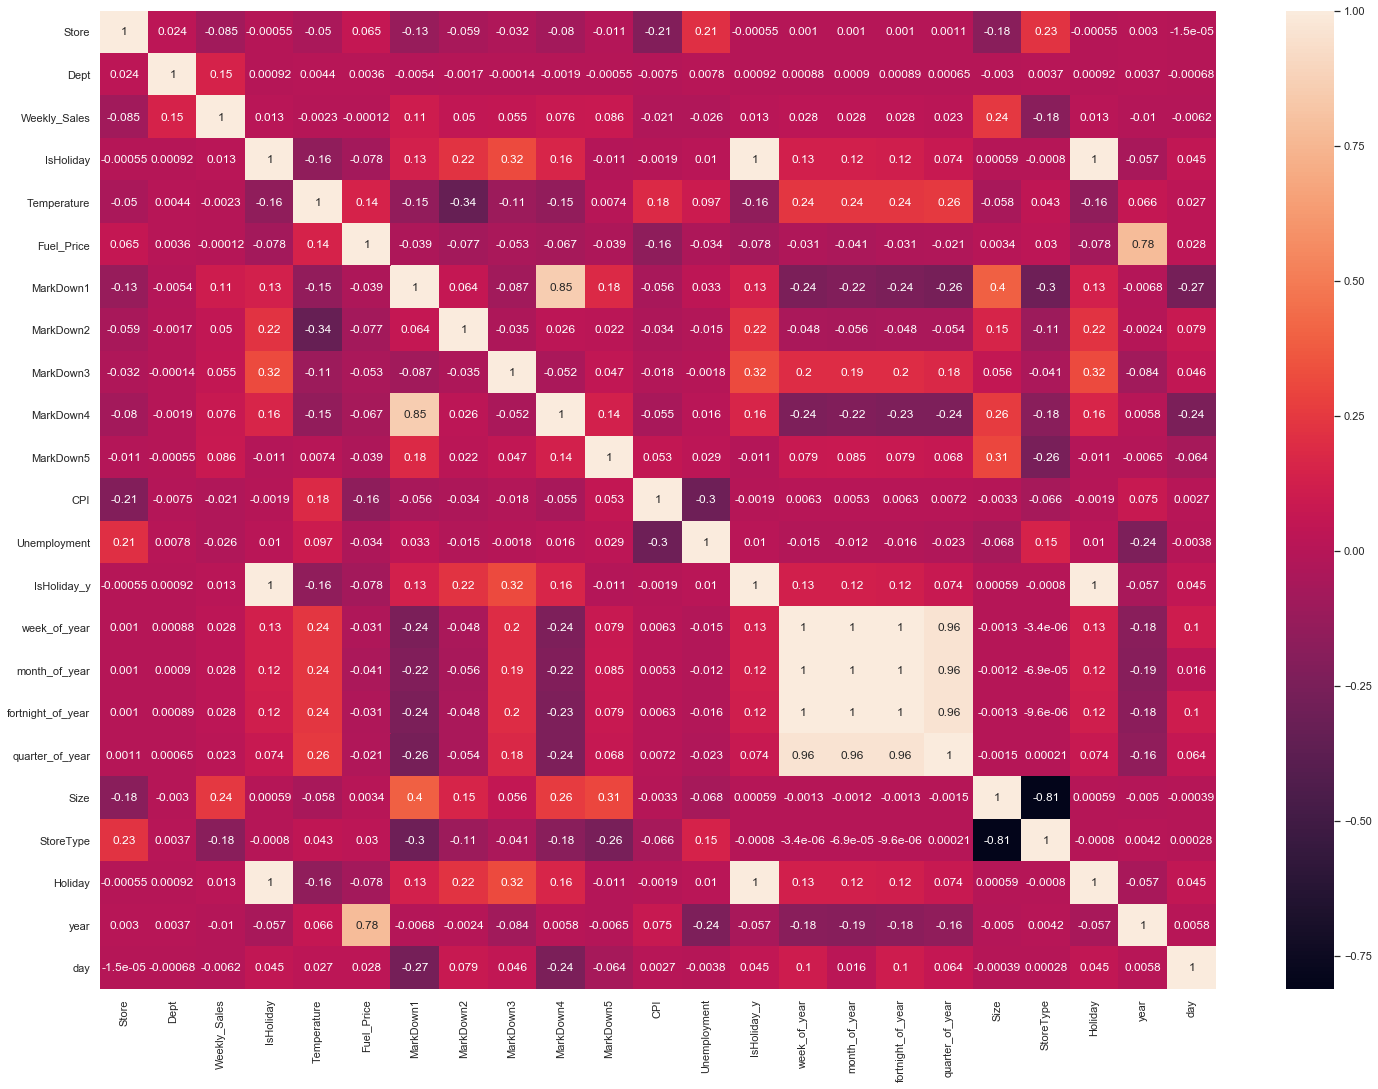

In [11]:
sns.set(rc={'figure.figsize':(25,18)})
sns.heatmap(train.corr(), annot=True)

In [19]:
df=train.corr()['Weekly_Sales']
#optimized_columns=['Store','Dept','week_of_year','month_of_year','year','day','Holiday','Temperature','Size','StoreType']


In [24]:
df[(df>.05) | (df<-.05)]

Store          -0.085195
Dept            0.148032
Weekly_Sales    1.000000
MarkDown1       0.106905
MarkDown3       0.054631
MarkDown4       0.075522
MarkDown5       0.085667
Size            0.243828
StoreType      -0.182242
Name: Weekly_Sales, dtype: float64

In [26]:
df

Store               -0.085195
Dept                 0.148032
Weekly_Sales         1.000000
IsHoliday            0.012774
Temperature         -0.002312
Fuel_Price          -0.000120
MarkDown1            0.106905
MarkDown2            0.049727
MarkDown3            0.054631
MarkDown4            0.075522
MarkDown5            0.085667
CPI                 -0.020921
Unemployment        -0.025864
IsHoliday_y          0.012774
week_of_year         0.027673
month_of_year        0.028409
fortnight_of_year    0.028022
quarter_of_year      0.022637
Size                 0.243828
StoreType           -0.182242
Holiday              0.012774
year                -0.010111
day                 -0.006187
Name: Weekly_Sales, dtype: float64